In [1]:
from nilearn.input_data import NiftiMasker, MultiNiftiMasker
from nilearn.datasets import fetch_atlas_basc_multiscale_2015
from nilearn.image import new_img_like
from fastsrm.fastsrm import FastSRM
from fastsrm.identifiable_srm import IdentifiableFastSRM
from nilearn import image, plotting
from shutil import copyfile
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import os
import glob
import ibc_public

%matplotlib inline

/home/sshankar/env/fastsrm/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
# Specify the mask image
_package_directory = os.path.dirname(os.path.abspath(ibc_public.__file__))
mask_gm = nib.load(os.path.join(_package_directory, '../ibc_data', 'gm_mask_3mm.nii.gz'))

In [3]:
# Task of interest
task = 'raiders'

In [4]:
# Do this for a previously unused atlas. 
# Else, you should have a .npy file saved from before, and you can just load it.
# The transform() funtion takes a few minutes to run so don't run it 
# unless you absolutely need to.

# Now, a bit of shape shifting to make the atlas compatible with
# what fastsrm.reduce_data() requires.
# 1. Add a 4th dimension to the 3D atlas. The 4th dimension will have as many
#   elements as atlas parcesl (444, in this case)
# 2. The 3D "volume" pertaining to each 4th dimension will contain 1 in the
#   "voxel" for that parcel and 0 otherwise
# 3. Apply the atlas masker set up previously to transform the new 4D atlas
#   into 2D, with n_voxel rows and n_parcel columns,
#   where n_voxel is the number of voxels in the transformed image matrix
# 4. Reduce the 2D atlas matrix to 1D by using the argmax function along the
#   column dimension. Now, the transformed atlas has n_voxel elements.

atlas_loc = os.path.join('..', task, '3mm')
if os.path.exists(os.path.join(atlas_loc, 'atlas_masked.npy')):
    atlas = np.load(os.path.join(atlas_loc, 'atlas_masked.npy'), allow_pickle=True)
else:
    # Specify the atlas
    basc444 = fetch_atlas_basc_multiscale_2015()['scale444']
    basc_im = image.load_img(basc444).get_data()

    atlas_masker = NiftiMasker(mask_img=mask_gm).fit()

    if len(basc_im.shape) == 3:
        n_components = len(np.unique(basc_im)) - 1
        xa, ya, za = basc_im.shape
        A = np.zeros((xa, ya, za, n_components + 1))
        atlas = np.zeros((xa, ya, za, n_components + 1))
        for c in np.unique(basc_im)[1:].astype(int):
            X_ = np.copy(basc_im)
            X_[X_ != c] = 0.
            X_[X_ == c] = 1.
            A[:, :, :, c] = X_
        atlas = atlas_masker.transform(new_img_like(basc444, A))
        atlas = np.argmax(atlas, axis=0)

    # # Save the transformed atlas
    np.save(os.path.join(atlas_loc, 'atlas_masked.npy'), atlas)

In [5]:
# Create a masker to standardize (0 mean, 1 SD) the image files
# and to transform them to a 2D array, as FastSRM requires
img_masker = MultiNiftiMasker(mask_img=mask_gm, 
                              standardize=True, 
                              smoothing_fwhm=5,
                              detrend=True,
                              high_pass=1./128,
                              t_r=2.0).fit()

In [98]:
# Any specific files that should be used for FastSRM
if task == 'clips':
    sessn = 3
    filepattern = 'wrdc*Trn*run-04*.nii.gz'
else:
    sessn = 2
    filepattern = 'wrdc*run-12*.nii.gz'

In [99]:
# Now create a list of movie session files 
movie_dir = os.path.join('..', task, '3mm/')
subs = sorted(glob.glob(movie_dir + 'sub*'))
nsub = 0
preproc_file = 'masked_imgs_preproc_run12.npy'

movie_arrays = []

# Number of sessions per subject
# Different tasks have different numbers of sessions.
# Also, all subjects might not have completed all sessions.
if task == 'clips':
    # For the clips task, one subject doesn't have all 4 sessions, and
    # FastSRM requires that all subjects have the same numbers of TRs
    sessn = 3
else:
    sessn = 2

# Create 2D masked arrays from image data and save to file for quick and easy access
for s, sub in enumerate(subs):
    if os.path.isdir(sub):
        nsub += 1
        sess = sorted(glob.glob(sub + '/ses*'))
        ses = sess[1]
       
        if os.path.exists(os.path.join(ses, preproc_file)):
            masked_imgs = np.load(os.path.join(ses, preproc_file), 
                                  allow_pickle=True)
        else:    
            movie_imgs = sorted(glob.glob(ses + '/' + filepattern))
            masked_imgs = img_masker.transform(movie_imgs)
            np.save(os.path.join(ses, preproc_file), masked_imgs)

        movie_arrays.append(masked_imgs)

In [103]:
for i in range(len(subs)):
    for j in range(len(movie_arrays[i])):
        print(movie_arrays[i][j].shape)
# movie_arrays[0][1].shape

(314, 46448)
(314, 46448)
(314, 46448)
(314, 46448)
(314, 46448)
(314, 46448)
(314, 46448)
(314, 46448)
(314, 46448)
(314, 46448)


In [100]:
# Create a list with all subjects' data
sub_movie = []

for i in range(0, nsub):
    sub_movie.append(np.concatenate(movie_arrays[i]).T)

In [ ]:
# Fit the FastSRM model with the data
fast_srm = IdentifiableFastSRM(
    atlas=atlas,
    n_components=20,
    n_jobs=1,
    n_iter=1000,
    n_iter_reduced=1000,
    temp_dir='/tmp',
    low_ram=True, 
    aggregate="mean",
    identifiability='decorr'
)
fast_srm.fit(sub_movie)

In [94]:
# Compute the shared temporal responses of subjects while watching the movie
shared_resp = fast_srm.transform(sub_movie)

In [95]:
# Save the shared response vector for future use
fastsrm_dir = os.path.join(movie_dir, 'fastsrm', 'single_run')
if not os.path.isdir(fastsrm_dir):
    os.mkdir(fastsrm_dir)

np.save(os.path.join(fastsrm_dir, 'shared_resp_run12_niter1000.npy'), shared_resp)

In [ ]:
from sklearn.preprocessing import scale

In [ ]:
scaled_resp = scale(shared_resp)

In [ ]:
scaled_resp.shape

In [ ]:
plt.plot(scaled_resp[2])

In [ ]:
np.save(os.path.join(fastsrm_dir, 'scaled_resp_run1.npy'), scaled_resp)

In [ ]:
from sklearn.preprocessing import normalize
norm_resp = normalize(shared_resp)
plt.plot(norm_resp[2])

In [ ]:
np.save(os.path.join(fastsrm_dir, 'norm_resp_run1.npy'), norm_resp)

In [ ]:
fastsrm_dir

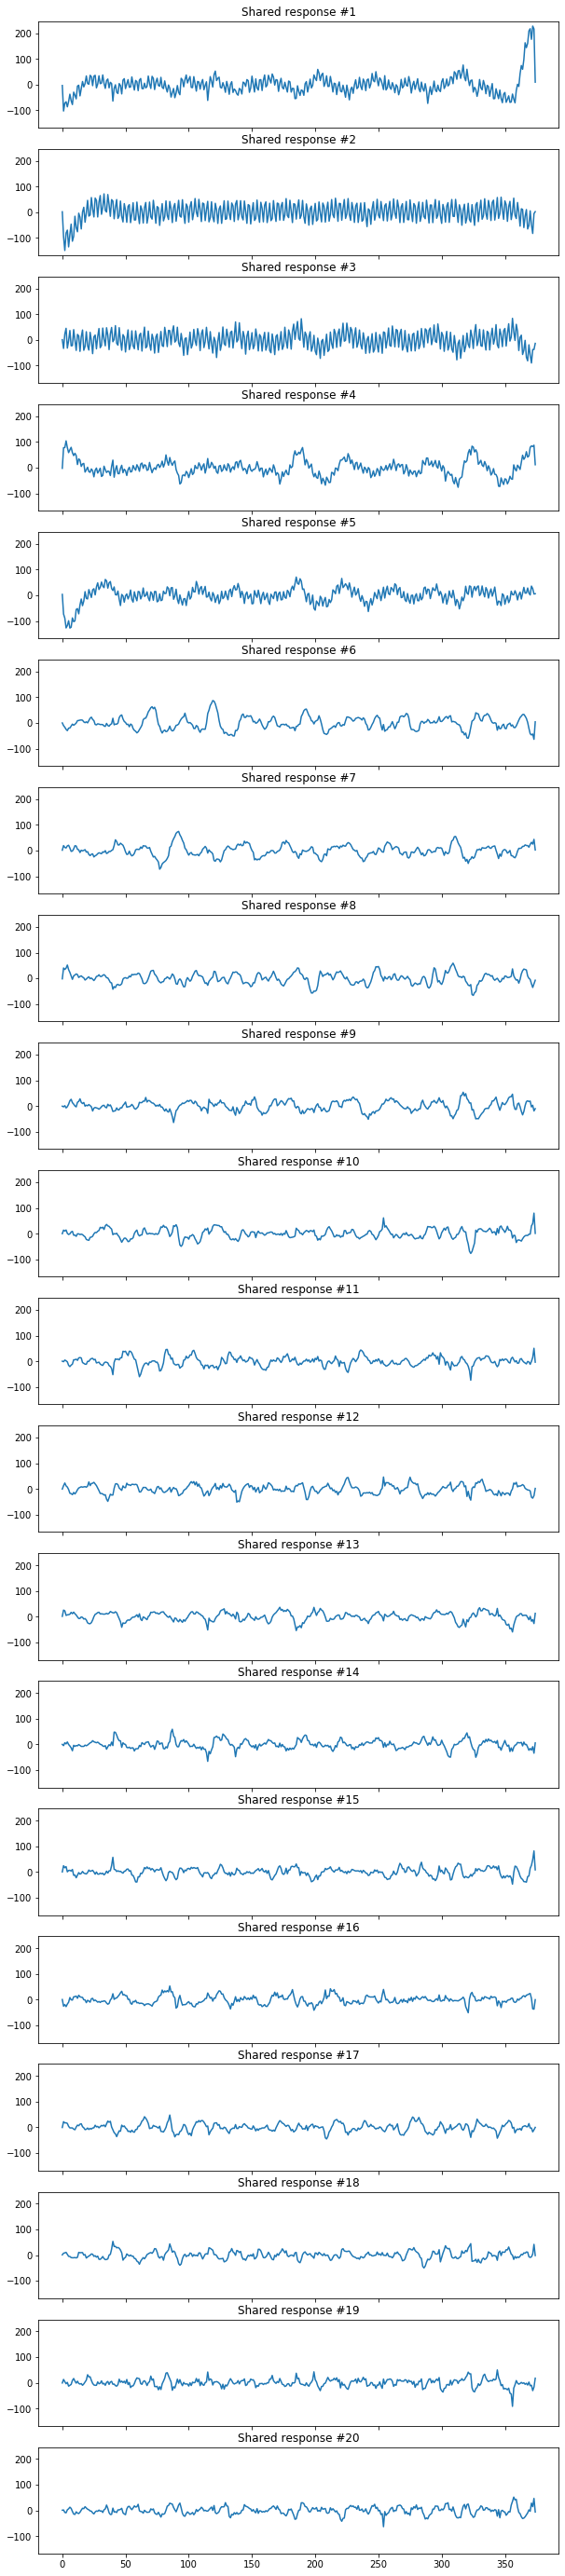

In [96]:
# These are what the shared responses look like
fig, axs = plt.subplots(20, sharex=True, sharey=True, 
                        figsize=(10,50))
# gridspec_kw={'hspace': 0.2}
for i in range(len(shared_resp)):
    axs[i].plot(shared_resp[i,:])
    axs[i].set_title('Shared response #' + str(i+1))
    

In [97]:
fig.savefig(os.path.join(fastsrm_dir, 'shared_resp_run12_niter1000.pdf'), format='pdf', transparent=False)

In [ ]:
# These are what the spatial maps look like, for one subject
bl1 = np.load('/tmp/fastsrm7cb4ce8e-1d76-4615-9c17-5a3cf6c57b16/basis_9.npy', allow_pickle=True)
inv_mask_bl1 = img_masker.inverse_transform(bl1)

for i in range(len(shared_resp)):
    plotting.plot_epi(inv_mask_bl1.slicer[...,i], draw_cross=False, 
                     cut_coords=7, display_mode='z', black_bg=True, cmap=plotting.cm.blue_red)

In [ ]:
# These are what the spatial maps look like, for a different subject
bl1 = np.load('/tmp/fastsrm7cb4ce8e-1d76-4615-9c17-5a3cf6c57b16/basis_5.npy', allow_pickle=True)
inv_mask_bl1 = img_masker.inverse_transform(bl1)

for i in range(len(shared_resp)):
    plotting.plot_epi(inv_mask_bl1.slicer[...,i], draw_cross=False, 
                     cut_coords=7, display_mode='z', black_bg=True, cmap=plotting.cm.blue_red)

In [ ]:
# The subject-specific spatial maps are in the parameter basis_list
# These spatial maps have been created using all runs from all subjects
fast_srm.basis_list

In [18]:
# Save the basis lists to subject folders for posterity
subs = sorted(glob.glob(movie_dir + 'sub*'))

for s, sub in enumerate(subs):
    srm_sub_dir = os.path.join(sub, 'fastsrm')
    if not os.path.isdir(srm_sub_dir):
        os.mkdir(srm_sub_dir)
    copyfile(fast_srm.basis_list[s], os.path.join(srm_sub_dir, 'basis_list_run3.npy'))

In [19]:
# Split the basis lists into their components and save them as 
# niimg-like files to use in other nistats/nilearn functions
subs = sorted(glob.glob(movie_dir + 'sub*'))

for s, sub in enumerate(subs):
    bls = np.load(os.path.join(sub, 'fastsrm', 'basis_list.npy'))
    for i in range(20):
        nib.save(img_masker.inverse_transform(bls[i]), 
                 os.path.join(sub, 'fastsrm', 'basis_list-' + str(i).zfill(2) + '_run3.nii.gz'))

On to second level model

In [20]:
# Import the necessary modules/functions
import pandas as pd
import numpy as np
from nistats.second_level_model import SecondLevelModel
from nistats.thresholding import map_threshold
from nilearn import plotting
from nistats.reporting import make_glm_report

In [21]:
# Let's gather the files that will form the input to the second level analysis
n_components = 20
second_level_input = np.empty((nsub,n_components), dtype='object')
subs = sorted(glob.glob(movie_dir + 'sub*'))

for s, sub in enumerate(subs):
    for c in range(n_components):
        second_level_input[s][c] = os.path.join(
            sub, 'fastsrm', 'basis_list-' + str(c).zfill(2) + '_run3.nii.gz')

In [ ]:
second_level_input

In [22]:
# Construct a design matrix. We are including all subjects and 
# essentially finding the "main effects" of the contrasts performed
# in the first level analysis
design_matrix = pd.DataFrame([1] * len(second_level_input), columns=['intercept'])

In [23]:
# Set up the second level analysis
second_level_model = SecondLevelModel(smoothing_fwhm=8)

In [24]:
# Compute the contrast/main effect
for i in range(20):
    z_map = second_level_model.fit(list(second_level_input[:,i]), 
                                    design_matrix=design_matrix).compute_contrast(output_type='z_score')
    nib.save(new_img_like(mask_gm, z_map.get_fdata()), 
             os.path.join(movie_dir, 'fastsrm', 'component-' + str(i).zfill(2) + '_run3.nii.gz'))
    #report = make_glm_report(second_level_model, 'intercept')
    #report.save_as_html(os.path.join(movie_dir, 'fastsrm', 'reduced-back', 'component-' + 
    #                                 str(i).zfill(2) + '.html'))